# ProcessStripsImage
## Looks at a static camera image and saves strip information to file.
#### Catherine Nicoloff, Wellesley College, June 2017
#### On behalf of Brandeis University and Brookhaven National Laboratory for the ATLAS ITk upgrade.

#### Turn on autoreload

In [1]:
%load_ext autoreload

<p><b>%autoreload</b>: Reload all modules (except those excluded by %aimport) automatically now.<br>
<b>%autoreload 0</b>: Disable automatic reloading.<br>
<b>%autoreload 1</b>: Reload all modules imported with %aimport every time before executing the Python code typed.<br>
<b>%autoreload 2</b>: Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.</p>
<p><b>%aimport</b>: List modules which are to be automatically imported or not to be imported.<br>
<b>%aimport foo</b>: Import module ‘foo’ and mark it to be autoreloaded for %autoreload 1<br>
<b>%aimport -foo</b>: Mark module ‘foo’ to not be autoreloaded.</p>

In [2]:
%autoreload 2

#### Show plots in the notebook

In [3]:
%matplotlib inline

#### Load modules

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2
#import imreg_dft as ird
import os
import sys
import re
import csv

#### Load additional definitions

In [5]:
import process_strips as p

#### Set plot formatting defaults

In [6]:
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

## Process Image(s)

#### Local variables

In [7]:
# Size of rectangle to analyze
rect = [250, 250]

# Analyze every nth column of the rectangle
step = 1

# Directory of images
img_dir = r'D:\Documents\School\Brookhaven\Images\2017-06-15\Fast Conversion Test'

# Directory where results are saved
save_dir = r'%s\%dx%d\Step %d' % (img_dir, rect[0], rect[1], step)

# Make the save directory, if it does not exist
p.make_dir(save_dir)

# Filename regex to match
match_pattern = "^.*.png$"
#match_pattern = "^image_([0-9]*)_([-0-9]*)_([-0-9]*)_([-0-9]*).png$"

# Sampling every nth file
# The file number modulo mod should equal remainder rem
mod = 1
rem = 0

#### Local definitions

In [8]:
# Gets the center coordinate of the image
def get_image_center(w, h):
    
    x_center = int(w/2.0)
    y_center = int(h/2.0)
    
    return x_center, y_center    

# Process the strips in the ROI and save the results
def process_ROI_and_save(img_gray, coords_max, save_dir, file_num):
    
    save_header = ['Column [px]', 'Row Start [px]', 'Row End [px]', 'Amplitudes [0-255]', 'Means [px]', 'Std. Dev. [px]', 'Error Amp [px]', 'Error Mean [px]', 'Error Std. Dev. [px]', 'dx']

    # Show the image with the ROI boxed
    print("     Displaying ROI...")
    img_center = p.draw_ROI(img_gray, coords_max, (255, 255, 255))
    plt.imshow(img_center, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title("Region of Interest, Outlined")
    plt.savefig("%s/%d_roi_outline.png" % (save_dir, file_num), dpi=300)
    plt.show()

    print("     Processing ROI...")
    img_light, results_light, numstrips = p.process_ROI(img_gray, coords_max, step, np.mean(img_gray), 20, 3.0)

    # Show the ROI
    plt.imshow(img_light, cmap = 'gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title("ROI Used")
    plt.savefig("%s/%d_roi.png" % (save_dir, file_num), dpi=300)
    plt.show()

    p.save_results("%s/%d_results.csv" % (save_dir, file_num), results_light, save_header)

    return numstrips

Loading file number 1: image_007_600_60_15.png


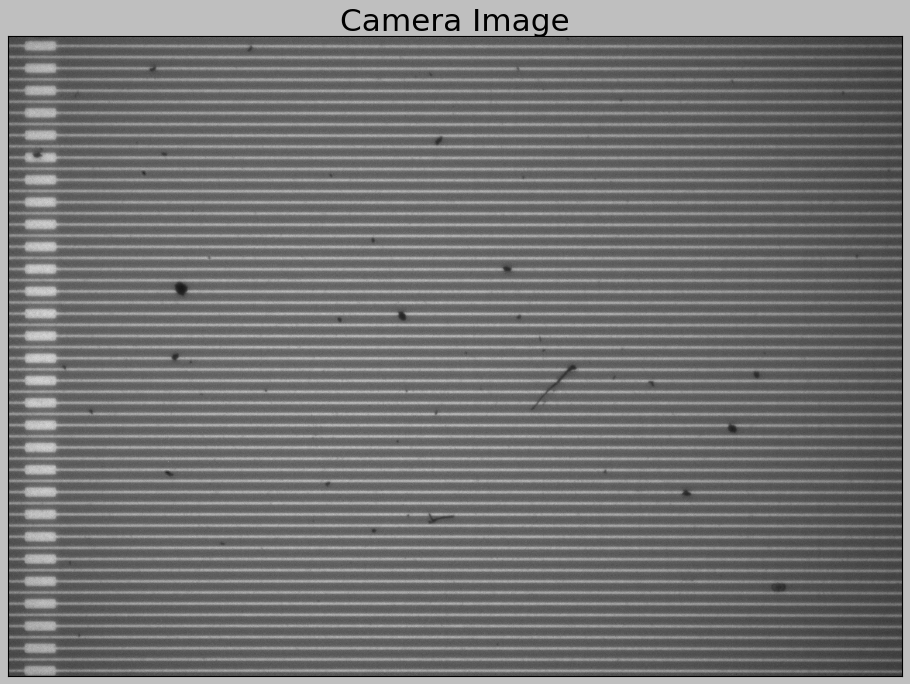

     Normalizing...


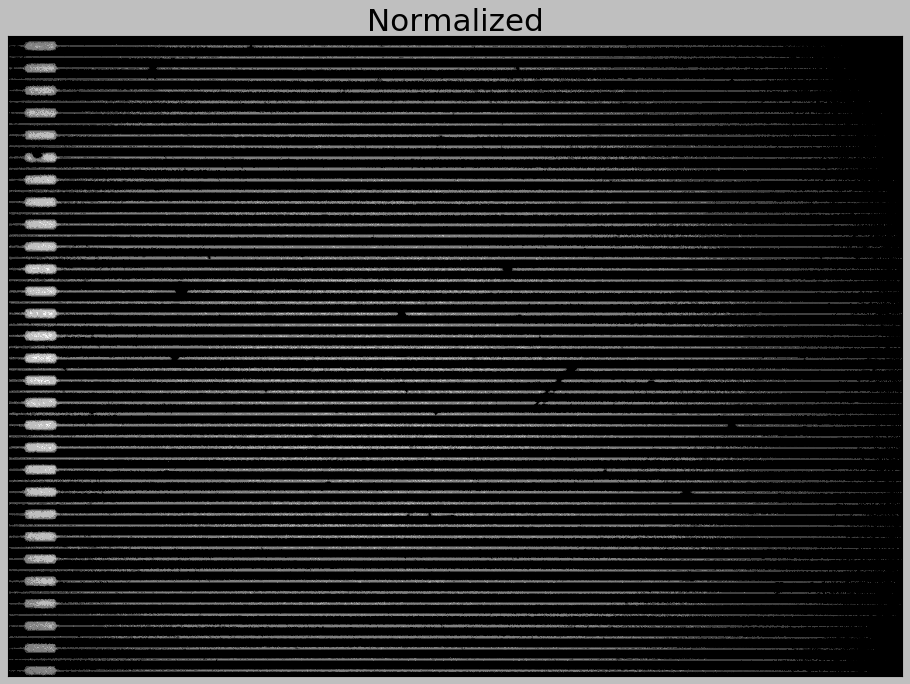

     Applying Otsu's threshold...


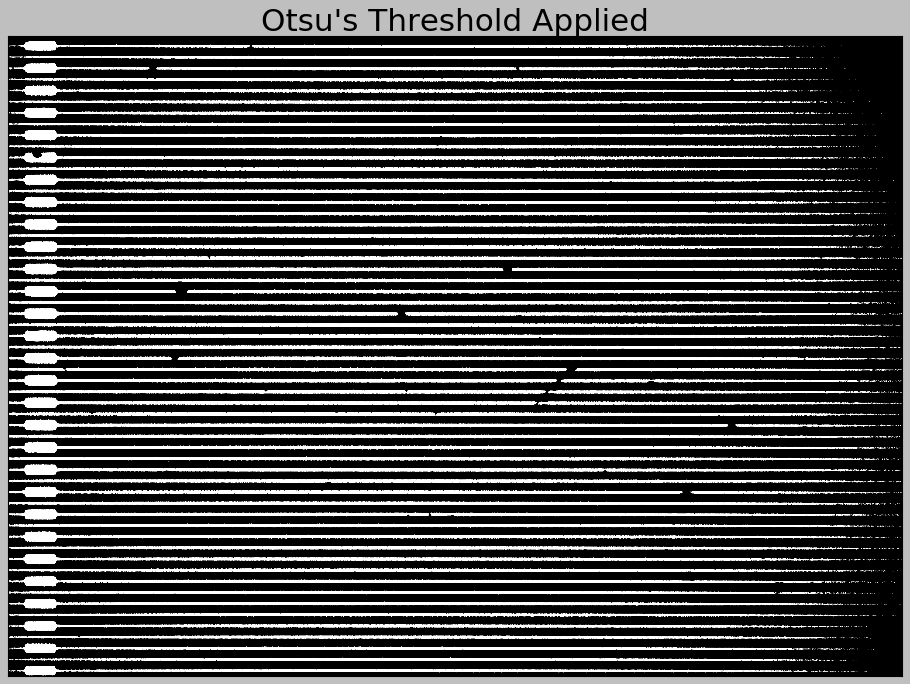

     Displaying ROI...


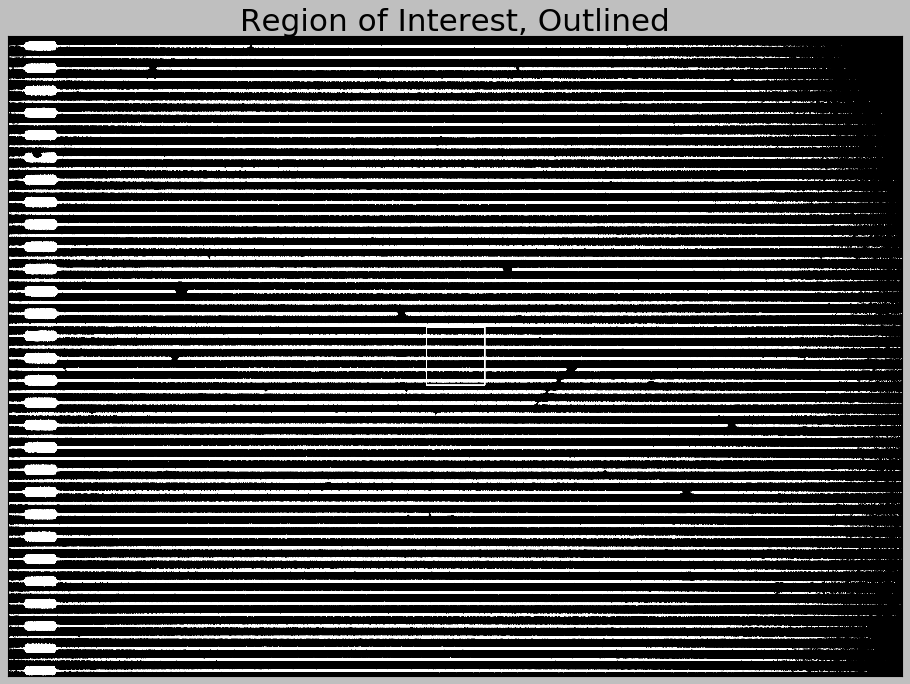

     Processing ROI...


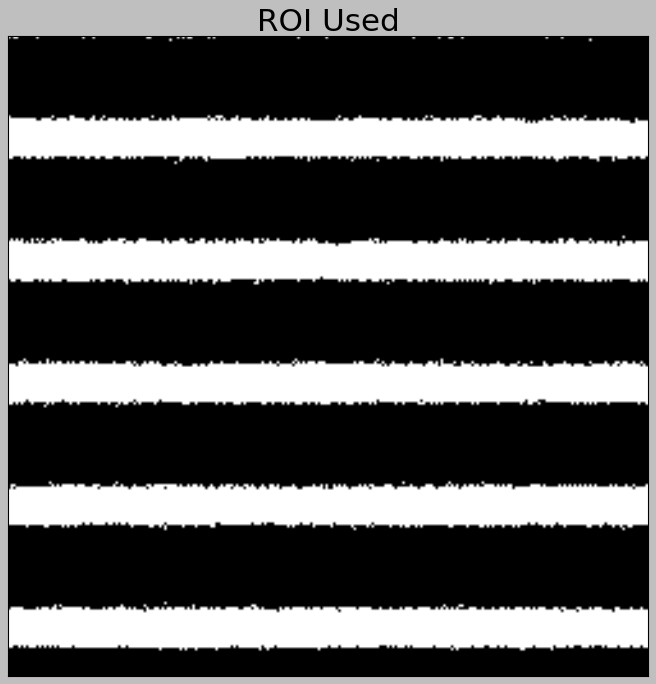

In [11]:
# Initialize result variables
scales = []
angles = []
success = []
results = {}
num = 0

# Get list of files in the image directory
filenames = next(os.walk(img_dir))[2]

# Iterate all the files
for fn in filenames:
    # Regex match on the filenames
    match = re.search(match_pattern, fn)

    # Pattern matched
    if match:
        # Get the file number from the pattern match
        try:
            file_num = int(match.group(1))
        except:
            num = num + 1
            file_num = num
            
        file_name = "%s\%s" % (img_dir, fn)

        # Sample every mod'th file in the directory, starting with file rem
        if (file_num % mod == rem):
            print("Loading file number %d: %s" % (file_num, fn))

            # Load the image file into an array
            # WARNING: This will fail if PIL is imported!
            img = cv2.imread(file_name)
            
            # Show the camera image
            plt.imshow(img, cmap = 'gray')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.title("Camera Image")
            plt.show()
            
            # Convert to grayscale
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Normalize the image
            print("     Normalizing...")
            # https://www.quora.com/What-are-the-ways-to-normalize-the-features-for-statistics-or-machine-learning-software
            img_mean = cv2.subtract(img_gray, np.mean(img_gray))
            img_mean = cv2.divide(img_mean, np.std(img_gray))

            # Old max and min of image
            img_min = int(np.min(img_mean))
            img_max = int(np.max(img_mean))

            # New range we'd like the values to have
            new_min = 0
            new_max = 255

            # https://en.wikipedia.org/wiki/Normalization_(image_processing)
            img_mean = cv2.subtract(img_mean, img_min)
            img_mean = cv2.multiply(img_mean, (new_max-new_min)/(img_max-img_min))
            img_mean = cv2.add(img_mean, new_min)
            
            plt.imshow(img_mean, cmap = 'gray')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.title("Normalized")
            plt.show()
            
            # ROI width and height
            h, w = np.shape(img_mean)
            
            # If rectangle is not set
            if (rect[0] == -1):
                rect[0] = w-1
            if (rect[1] == -1):
                rect[1] = h-1

            # Free some allocated memory
            del img

            # Use OpenCV's Otsu threshold to binarize the image
            print("     Applying Otsu's threshold...")
            img_otsu = p.otsu_threshold(img_mean, 0, 255)
            plt.imshow(img_otsu, cmap = 'gray')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.title("Otsu's Threshold Applied")
            plt.savefig("%s/%d_otsu_threshold.png" % (save_dir, file_num), dpi=300)
            plt.show()
            
            # Take a rectangle from the center of the image and process
            img_center = get_image_center(w, h)
            img_roi = p.check_ROI(img_center, rect, w, h)
            numstrips = process_ROI_and_save(img_otsu, img_roi, save_dir, file_num)

            # Free some allocated memory
            del img_otsu